### Streamlining Your Research Laboratory with Python
* Authors:   Mark F. Russo, Ph.D and William Neil 
* Publisher: John Wiley & Sons, Inc.
* License:   MIT (https://opensource.org/licenses/MIT)

In [1]:
# Import modules
import pandas as pd
import matplotlib.pyplot as plt
import random

In [2]:
# Utility: Generate CSV file with Substance ID map of source rack
# 40 source tubes in 8 rows and 5 columns of an 8x8 source tube rack
def gen_source_map(sfile='source_map.csv'):
    tbl = []
    for i in range(40):
        tbl.append( [f'{chr(i//5+65)}{i%5+1:02d}',f'T{i+1:02d}','T'] )
        
    # Add negative and positive controls
    for i in range(4):
        tbl.append( [f'{chr(i+65)}07',f'N{i+1:02d}','N'] )
        tbl.append( [f'{chr(i+65)}08',f'P{i+1:02d}','P'] )
    
    with open(sfile, 'w') as file:
        file.write('src,ID,type\n')
        for row in tbl:
            file.write(','.join(row)+'\n')

# Utility to fabricate data and write data file
def generate_measurements(df, fname = 'data_screen.csv'):
    random.seed(123)
    cdf = df.copy()
    
    # Randomly pick two hits
    h1 = f'T{random.randint(1,40):02d}'
    h2 = f'T{random.randint(1,40):02d}'
    # print(h1, h2)
    
    meas = []
    for _, row in cdf.iterrows():
        ID = row['ID']
        
        val = 0.0
        if ID in [h1, h2]:          # Hits
            val = random.gauss(mu=0.05, sigma=0.02)
        elif ID[0] == 'N':          # Negative controls
            val = 0.5 - random.random() * 0.02
        elif ID[0] == 'P':          # Positive controls
            val = random.random() * 0.02
        else:                       # Non-hits
            val = random.gauss(mu=0.4, sigma=0.02)
        meas.append( f'{val:.3f}' )
    
    cdf['meas'] = meas
    data = cdf.loc[:,['dest','meas']]
    data.to_csv(fname, index=False)

# gen_source_map()

In [3]:
# Build initial experiment DataFrame with duplicate tests and save
def build_duplicate_experiment(sfile='source_map.csv'):
    # Read Source Map into DataFrame
    sdf = pd.read_csv(sfile)
    
    # Generate DataFrame with randomized plate layout for testing
    # Duplicate source map using concat() method
    df         = pd.concat( [sdf, sdf], ignore_index=True)
    
    # Add transfer volumes to 'vol' column. 100 mL each.
    df['vol']  = [100]*96
    
    # Generate well labels, shuffle randomly. Add to 'dest' column.
    dests      = [f'{chr(i//12+65)}{i%12+1:02d}' for i in range(96)]
    random.shuffle(dests)
    df['dest'] = dests
    
    # Return generated DataFrame
    return df

In [4]:
# To start analysis build the experiment DataFrame
df = build_duplicate_experiment(sfile='source_map.csv')

# Save entire experiment DataFrame to file for use in future
df.to_csv('experiment.csv', index=False)

# Write worklist for liquid handler
wl = df[['src','dest','vol']]
wl.to_csv('worklist.csv', index=False)

# Also generate fictive measurement data and write data file
generate_measurements(df)

In [5]:
# Merge measured data into main experiment DataFrame
def merge_measurements(efile='experiment.csv', mfile='data_screen.csv'):
    # Read experiment data
    df = pd.read_csv(efile)
    
    # Read measurements
    data = pd.read_csv(mfile)
    
    # Merge experimental data into DataFrame
    df = pd.merge(df, data, on='dest')
    
    # Add a computed column to DataFrame with Normalized Percent Inhibition
    mpos = df.loc[df.type == 'P']['meas'].mean()
    mneg = df.loc[df.type == 'N']['meas'].mean()
    df['NPI'] = 100.0 * (1.0 - (mpos - df['meas'])/(mpos - mneg))
    
    return df

# Z-factor QC measure
def Z_factor(df):
    sdpos  = df.loc[df.type == 'P']['NPI'].std()    # P-stdev
    sdsamp = df.loc[df.type == 'T']['NPI'].std()    # N-stdev
    mpos   = df.loc[df.type == 'P']['NPI'].mean()   # P-mean
    msamp  = df.loc[df.type == 'T']['NPI'].mean()   # N-mean
    zprime = 1.0 - 3.0*(sdpos + sdsamp)/abs(mpos - msamp)
    return zprime

# Find hits as tests with NPI outlier values
def find_hits(df):
    desc = df.loc[df.type == 'T']['NPI'].describe() # Describe data set
    IQR  = desc['75%'] - desc['25%']                # Compute IQR
    hits = df[(df.type == 'T') & (df.NPI >= (desc['75%'] + 1.5*IQR))]
    return hits

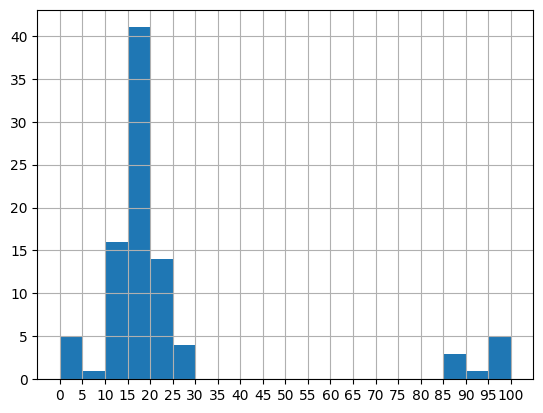

In [6]:
# Read data, merge measurements, and add NPI
df = merge_measurements(efile='experiment.csv', mfile='data_screen.csv')

# Visualize NPI as histogram
plt.hist(df['NPI'], bins=[5*b for b in range(21)])
plt.xticks([5*b for b in range(21)])
plt.grid()

# # Visualize measurements as a histogram
# plt.hist(df.meas, bins=[b*0.025 for b in range(21)]);
# plt.xticks([0.05*b for b in range(11)])
# plt.grid()

In [7]:
# Compute Z-factor as a quality control method
z = Z_factor(df)
print(f'Z-factor: {z}')

# Get hits by looking for outliers where NPI >= Quartile3 + 1.5 * IQR
hits = find_hits(df)
display(hits)

Z-factor: 0.3410549880920045


,src,ID,type,vol,dest,meas,NPI
3,A04,T04,T,100,B04,0.077,85.484707
17,D03,T18,T,100,E02,0.057,89.631934
51,A04,T04,T,100,C01,0.035,94.193883
65,D03,T18,T,100,F10,0.074,86.106791
